In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", header = None)


# print(df.iloc[0].values)
# print(df[df[1] == "India"].transpose())
india_df = pd.DataFrame(df[df[1] == "India"].transpose().values, df.iloc[0].values)

india_df.columns=['Cases'] 

india_df = india_df.drop(labels=["Province/State", "Country/Region", "Lat", "Long"], axis=0)

india_df.index = pd.to_datetime(india_df.index)
india_df['Cases'] = india_df['Cases'].astype(float)

india_df['New Cases']= india_df['Cases']-india_df['Cases'].shift(1)

print(india_df.tail())

print(india_df.dtypes)


                 Cases  New Cases
2021-09-07  33096718.0    37875.0
2021-09-08  33139981.0    43263.0
2021-09-09  33174954.0    34973.0
2021-09-10  33208330.0    33376.0
2021-09-11  33236921.0    28591.0
Cases        float64
New Cases    float64
dtype: object


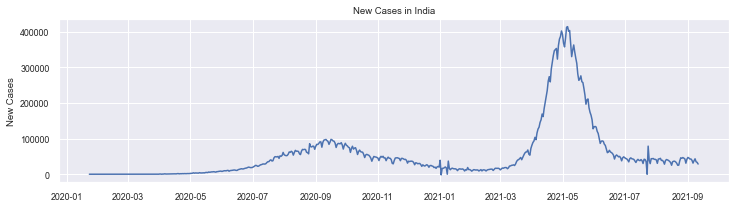

In [2]:
sns.set(font_scale=0.8)

plt.figure(figsize = (12, 3))

ax = sns.lineplot(x = india_df.index, y  = "New Cases", data = india_df)

plt.title("New Cases in India")
plt.show()

In [3]:
india_df[india_df["New Cases"] == 0]
india_df.drop(india_df.index[india_df["New Cases"] == 0], axis = 0, inplace = True)

In [4]:
current_death_plot = india_df[-120:]

In [5]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
#test_result=adfuller(total_death_plot.iloc[-100:]['new_cases'])


#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(current_death_plot['New Cases'])

ADF Test Statistic : -4.487516406610297
p-value : 0.00020710934286467364
#Lags Used : 8
Number of Observations Used : 111
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


# PACF and ACF Plots

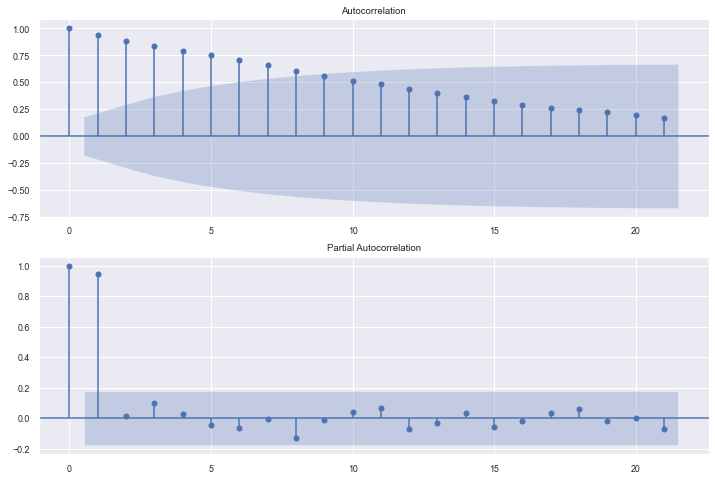

In [6]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(current_death_plot['New Cases'], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(current_death_plot['New Cases'], ax=ax2)

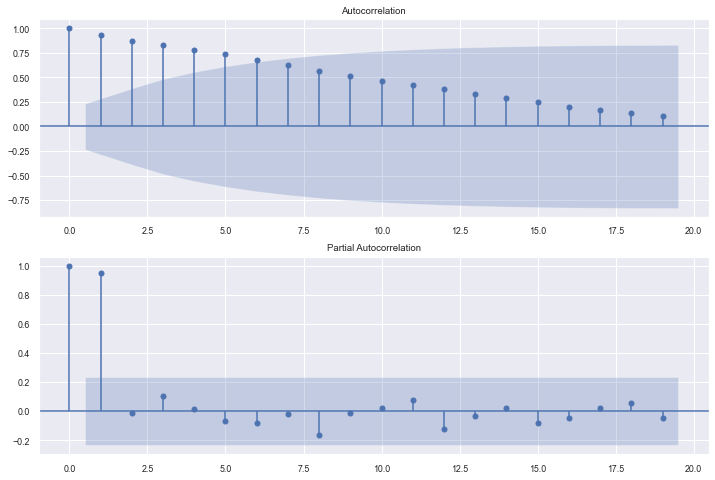

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

training_data = current_death_plot.iloc[:-50]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data['New Cases'], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data['New Cases'], ax=ax2)

In [43]:
from pmdarima import auto_arima

import warnings

warnings.filterwarnings("ignore")


stepwise_fit = auto_arima(current_death_plot["New Cases"], d = 1, stepwise=True, trace = True, suppress_warnings = True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2520.951, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2527.013, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2527.381, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2527.318, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2532.640, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2520.733, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2518.596, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2522.335, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2525.413, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2527.733, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2524.802, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.161 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1255.298
Date:                Sun, 12 Sep 2021   AIC                           2518.596
Time:                        19:21:25   BIC                           2529.712
Sample:                             0   HQIC                          2523.110
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2384.4447    743.571     -3.207      0.001   -3841.818    -927.072
ma.L1         -0.0493      0.044     -1.123      0.261      -0.135       0.037
ma.L2         -0.0885      0.089     -0.996      0.319      -0.263       0.086
sigma2      8.363e+07      0.016   5.23e+09      0.000    8.36e+07    8.36e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               170.30
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+25. Standard errors may be unstable.
"""

In [9]:
from statsmodels.tsa.arima.model import ARIMA

testing_data = current_death_plot.iloc[-50:]

model=ARIMA(training_data['New Cases'],order=(7, 1, 1))
model_fit=model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              New Cases   No. Observations:                   70
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -802.264
Date:                Sun, 12 Sep 2021   AIC                           1622.528
Time:                        19:07:04   BIC                           1642.635
Sample:                    05-14-2021   HQIC                          1630.505
                         - 07-22-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6034      0.034    -17.754      0.000      -0.670      -0.537
ar.L2         -0.1009      0.013     -7.640      0.000      -0.127      -0.075
ar.L3         -0.0900      0.010     -8.721      0.000      -0.110      -0.070
ar.L4          0.0027      0.008      0.354      0.724      -0.012       0.018
ar.L5          0.0482      0.014      3.472      0.001       0.021       0.075
ar.L6         -0.0065      0.010     -0.620      0.535      -0.027       0.014
ar.L7          0.0318      0.005      5.803      0.000       0.021       0.043
ma.L1          0.5796      0.033     17.381      0.000       0.514       0.645
sigma2      1.569e+07   1.04e-09   1.51e+16      0.000    1.57e+07    1.57e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.42   Jarque-Bera (JB):                 9.42
Prob(Q):                              0.02   Prob(JB):                         0.01
Heteroskedasticity (H):               0.12   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+31. Standard errors may be unstable.
"""

In [10]:
start = len(training_data)
end = len(training_data) + len(testing_data) -1
pred = model_fit.predict(start = start, end = end, typ = 'levels')
pred.index = current_death_plot.index[start: end + 1]
print(pred)

2021-07-24    34699.309594
2021-07-25    35514.096208
2021-07-26    36160.698659
2021-07-27    35365.610984
2021-07-28    35797.058135
2021-07-29    35549.163532
2021-07-30    35579.898131
2021-07-31    35550.846635
2021-08-01    35572.136641
2021-08-02    35605.283663
2021-08-03    35545.823027
2021-08-04    35593.161421
2021-08-05    35558.197866
2021-08-06    35582.145875
2021-08-07    35567.341262
2021-08-08    35574.727356
2021-08-09    35573.235862
2021-08-10    35570.905694
2021-08-11    35574.642696
2021-08-12    35570.797442
2021-08-13    35574.158966
2021-08-14    35571.586044
2021-08-15    35573.287389
2021-08-16    35572.355468
2021-08-17    35572.703055
2021-08-18    35572.733032
2021-08-19    35572.500333
2021-08-20    35572.809412
2021-08-21    35572.506947
2021-08-22    35572.756128
2021-08-23    35572.577443
2021-08-24    35572.687795
2021-08-25    35572.633364
2021-08-26    35572.647845
2021-08-27    35572.657980
2021-08-28    35572.635761
2021-08-29    35572.661089
2

<AxesSubplot:>

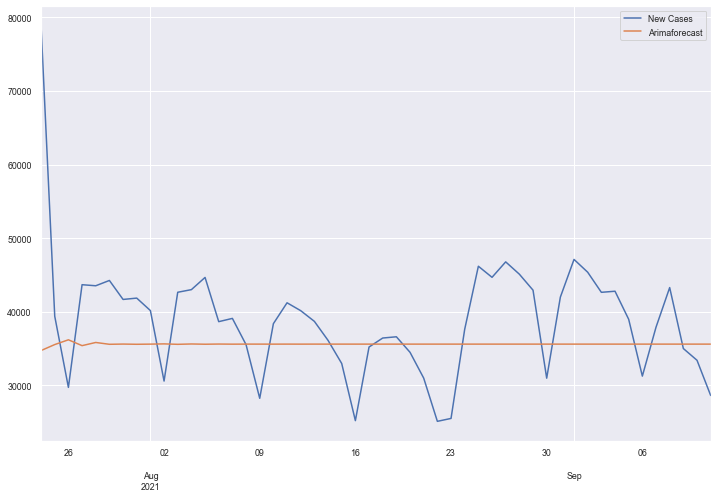

In [11]:
testing_data['Arimaforecast'] = pred
testing_data[['New Cases','Arimaforecast']].plot(figsize=(12,8))

In [44]:
entire_model = ARIMA(current_death_plot['New Cases'],order=(0, 1, 2))
model_fit2=entire_model.fit()

model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              New Cases   No. Observations:                  120
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1259.401
Date:                Sun, 12 Sep 2021   AIC                           2524.802
Time:                        19:21:49   BIC                           2533.139
Sample:                             0   HQIC                          2528.188
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0495      0.045     -1.107      0.268      -0.137       0.038
ma.L2         -0.0896      0.080     -1.124      0.261      -0.246       0.067
sigma2      8.848e+07   4.47e-10   1.98e+17      0.000    8.85e+07    8.85e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               170.29
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.83e+31. Standard errors may be unstable.
"""

In [45]:
pred2 = model_fit2.predict(start = len(current_death_plot), end = len(current_death_plot) + 30, typ = 'levels')

index_future_dates = pd.date_range(start = '2021-09-12', end = '2021-10-12')

pred2.index = index_future_dates 

print(pred2)

2021-09-12    29001.343905
2021-09-13    29496.904723
2021-09-14    29496.904723
2021-09-15    29496.904723
2021-09-16    29496.904723
2021-09-17    29496.904723
2021-09-18    29496.904723
2021-09-19    29496.904723
2021-09-20    29496.904723
2021-09-21    29496.904723
2021-09-22    29496.904723
2021-09-23    29496.904723
2021-09-24    29496.904723
2021-09-25    29496.904723
2021-09-26    29496.904723
2021-09-27    29496.904723
2021-09-28    29496.904723
2021-09-29    29496.904723
2021-09-30    29496.904723
2021-10-01    29496.904723
2021-10-02    29496.904723
2021-10-03    29496.904723
2021-10-04    29496.904723
2021-10-05    29496.904723
2021-10-06    29496.904723
2021-10-07    29496.904723
2021-10-08    29496.904723
2021-10-09    29496.904723
2021-10-10    29496.904723
2021-10-11    29496.904723
2021-10-12    29496.904723
Freq: D, Name: predicted_mean, dtype: float64


<AxesSubplot:>

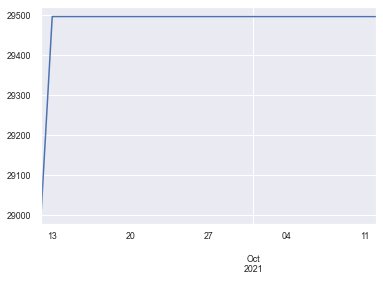

In [46]:
pred2.plot()

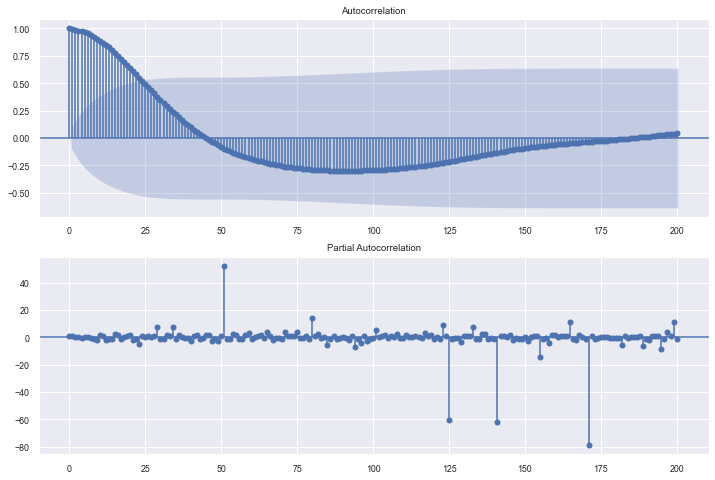

In [47]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(india_df['New Cases'][-450:], ax=ax1, lags = 200)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(india_df['New Cases'][-450:], ax=ax2, lags = 200)

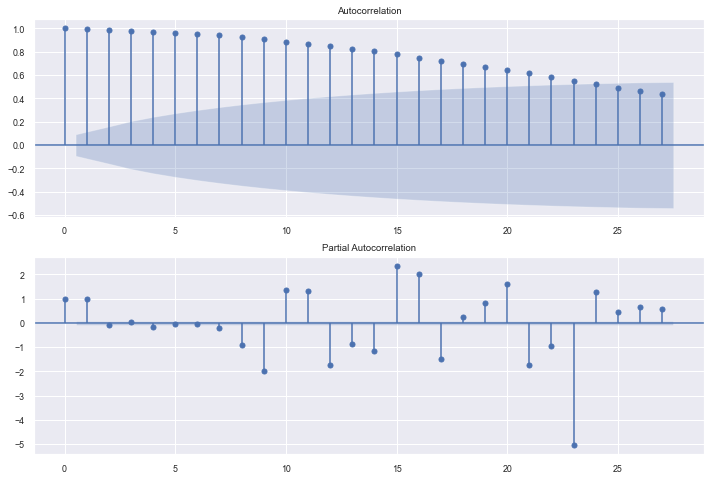

In [48]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(india_df['New Cases'][-450:], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(india_df['New Cases'][-450:], ax=ax2)

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model=SARIMAX(training_data['New Cases'],order=(0,1,2), seasonal_order = (1, 0, 0, 3))
model_fit3=model.fit(disp=0)
model_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          New Cases   No. Observations:                   70
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 3)   Log Likelihood                -728.205
Date:                            Sun, 12 Sep 2021   AIC                           1464.410
Time:                                    19:22:14   BIC                           1473.347
Sample:                                05-14-2021   HQIC                          1467.956
                                     - 07-22-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0289      0.029     -0.998      0.318      -0.086       0.028
ma.L2         -0.0799      0.040     -2.021      0.043      -0.157      -0.002
ar.S.L3       -0.0355      0.027     -1.301      0.193      -0.089       0.018
sigma2      6.859e+07   7.55e-11   9.09e+17      0.000    6.86e+07    6.86e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.76   Jarque-Bera (JB):                 9.89
Prob(Q):                              0.10   Prob(JB):                         0.01
Heteroskedasticity (H):               0.11   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [50]:
start = len(training_data)
end = len(training_data) + len(testing_data) -1
pred3 = model_fit3.predict(start = start, end = end, typ = 'levels')
pred3.index = current_death_plot.index[start: end + 1]
print(pred3)

2021-07-24    35158.839878
2021-07-25    35615.694090
2021-07-26    35830.194030
2021-07-27    35836.697562
2021-07-28    35820.475877
2021-07-29    35812.859551
2021-07-30    35812.628628
2021-07-31    35813.204617
2021-08-01    35813.475052
2021-08-02    35813.483252
2021-08-03    35813.462800
2021-08-04    35813.453197
2021-08-05    35813.452906
2021-08-06    35813.453633
2021-08-07    35813.453973
2021-08-08    35813.453984
2021-08-09    35813.453958
2021-08-10    35813.453946
2021-08-11    35813.453946
2021-08-12    35813.453946
2021-08-13    35813.453947
2021-08-14    35813.453947
2021-08-15    35813.453947
2021-08-16    35813.453947
2021-08-17    35813.453947
2021-08-18    35813.453947
2021-08-19    35813.453947
2021-08-20    35813.453947
2021-08-21    35813.453947
2021-08-22    35813.453947
2021-08-23    35813.453947
2021-08-24    35813.453947
2021-08-25    35813.453947
2021-08-26    35813.453947
2021-08-27    35813.453947
2021-08-28    35813.453947
2021-08-29    35813.453947
2

<AxesSubplot:>

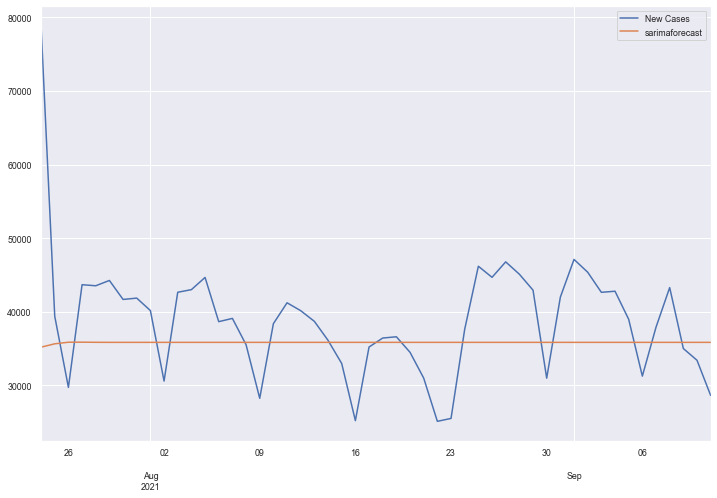

In [51]:
testing_data['sarimaforecast'] = pred3
testing_data[['New Cases','sarimaforecast']].plot(figsize=(12,8))

In [52]:
entire_model = SARIMAX(current_death_plot['New Cases'],order=(0,1,2), seasonal_order = (1, 0, 0, 3))
model_fit4=entire_model.fit()

model_fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          New Cases   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 3)   Log Likelihood               -1258.960
Date:                            Sun, 12 Sep 2021   AIC                           2525.921
Time:                                    19:22:25   BIC                           2537.037
Sample:                                         0   HQIC                          2530.435
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0484      0.044     -1.103      0.270      -0.135       0.038
ma.L2         -0.0884      0.072     -1.223      0.221      -0.230       0.053
ar.S.L3       -0.0262      0.027     -0.974      0.330      -0.079       0.027
sigma2      8.848e+07   3.33e-10   2.65e+17      0.000    8.85e+07    8.85e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               189.00
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.82e+32. Standard errors may be unstable.
"""

In [53]:
pred4 = model_fit4.predict(start = len(current_death_plot), end = len(current_death_plot) + 30, typ = 'levels')

index_future_dates = pd.date_range(start = '2021-09-12', end = '2021-10-12')

pred4.index = index_future_dates 

print(pred4)


2021-09-12    29190.340781
2021-09-13    29708.814699
2021-09-14    29834.207277
2021-09-15    29818.501345
2021-09-16    29804.914557
2021-09-17    29801.628601
2021-09-18    29802.040180
2021-09-19    29802.396227
2021-09-20    29802.482336
2021-09-21    29802.471551
2021-09-22    29802.462220
2021-09-23    29802.459964
2021-09-24    29802.460246
2021-09-25    29802.460491
2021-09-26    29802.460550
2021-09-27    29802.460543
2021-09-28    29802.460536
2021-09-29    29802.460535
2021-09-30    29802.460535
2021-10-01    29802.460535
2021-10-02    29802.460535
2021-10-03    29802.460535
2021-10-04    29802.460535
2021-10-05    29802.460535
2021-10-06    29802.460535
2021-10-07    29802.460535
2021-10-08    29802.460535
2021-10-09    29802.460535
2021-10-10    29802.460535
2021-10-11    29802.460535
2021-10-12    29802.460535
Freq: D, Name: predicted_mean, dtype: float64


<AxesSubplot:>

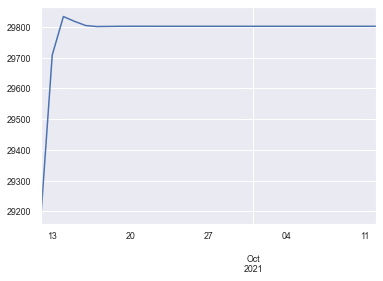

In [54]:
pred4.plot()

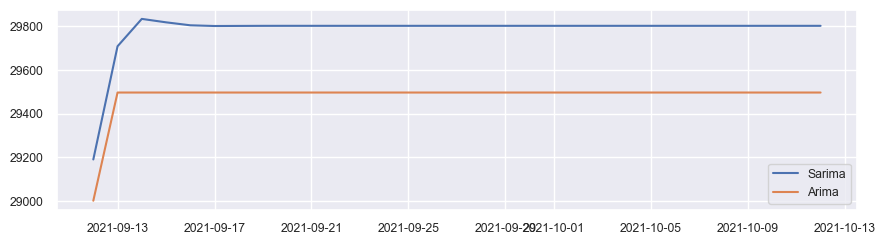

In [55]:
fig = plt.figure(figsize = (8, 2), dpi = 100) 
ax = fig.add_axes([0,0,1,1])

ax.plot(pred4,  label = "Sarima")

ax.plot(pred2, label = "Arima")

ax.legend(loc='best')

fig.show()

#### ARIMA(10, 1, 1)

#### SARIMA(0,1,4)(1, 0, 0, 3)